This script requires the csv files containing the dice sores between any two scans as input.

These csvs are generated using the following script: `analysis/dice_scores/calculate_dice_scores.sh`

In [7]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

DICE_ROOT = "/Users/amelie/Datasets/clinical_dmri_benchmark/dice_scores"

In [8]:
def read_bundle_txt(path_to_bundle_list: str) -> list:
    """Reads a text file of all reconstructed bundle names and returns a python list

    Args:
    path_to_bundle_list: Path to the txt file containing names from reconstructed bundles
                         Each bundle name is expected to be in a new line

    Returns:
    List of bundle names
    """
    bundle_names = []
    with open(path_to_bundle_list, "r") as bundle_list:
        # Iterate over the lines of the file
        for line in bundle_list:
            # Remove the newline character at the end of the line
            bundle_name = line.strip()

            # Append the line to the list
            bundle_names.append(bundle_name)
    return bundle_names

bundle_names = read_bundle_txt("../../data/bundle_names.txt")

In [ ]:
# read dice score csvs and extract median within and between subject dice scores per bundle
dice_list = []
sep = "_"

for bundle_name in bundle_names:
    for reconstruction in ["GQI", "CSD", "SS3T"]:
        bundle_name_short = bundle_name.split(sep=sep, maxsplit=1)[1]
        bundle_file = f"{DICE_ROOT}/{reconstruction}/{bundle_name.replace("_", "").replace("-", "")}.csv"
        
        # Load CSV as numpy array for efficiency
        bundle_array = pd.read_csv(bundle_file, index_col=0, na_values=[""]).values

        # Process intra-dices
        intra_dices = np.diag(bundle_array, k=1)[::2]
        intra_dices = intra_dices[~np.isnan(intra_dices)]
        dice_list.extend([[np.median(intra_dices), bundle_name_short, "within subject", reconstruction]])

        # Process inter-dices
        inter_dices_1 = np.diag(bundle_array, k=1)[1::2]
        inter_dices_2 = bundle_array[np.triu_indices_from(bundle_array, k=2)]
        inter_dices = np.hstack((inter_dices_1, inter_dices_2))
        inter_dices = inter_dices[~np.isnan(inter_dices)]
        dice_list.extend([[np.median(inter_dices), bundle_name_short, "between subjects", reconstruction]])

# Convert to DataFrame after processing all bundles
dice_df = pd.DataFrame(dice_list, columns=["dice score", "bundle", "inter vs. intra", "method"])

# Create a new column to represent unique combinations of method + inter vs. intra
dice_df["method_category"] = dice_df["method"] + " (" + dice_df["inter vs. intra"] + ")"

# Sort by method and inter vs. intra to ensure consistent order
dice_df["method_category"] = pd.Categorical(
    dice_df["method_category"],
    categories=[
        "GQI (within subject)", "GQI (between subjects)",
        "CSD (within subject)", "CSD (between subjects)",
        "SS3T (within subject)", "SS3T (between subjects)"
    ],
    ordered=True
)

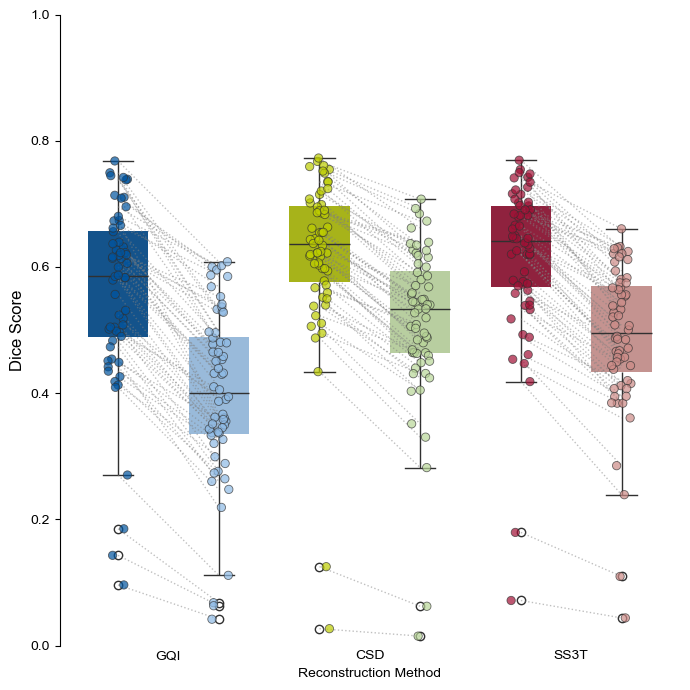

In [10]:
# Plot
# Set font, figure size and colors
mpl.rcParams["font.family"] = "Arial"
figsize = (7, 7)
custom_colors = {
    "GQI (within subject)": (0, 84/255, 159/255),
    "GQI (between subjects)": (142/255, 186/255, 229/255),
    "CSD (within subject)": (189/255, 205/255, 0),
    "CSD (between subjects)": (184/255, 214/255, 152/255),
    "SS3T (within subject)": (161/255, 16/255, 53/255),
    "SS3T (between subjects)": (205/255, 139/255, 135/255),
}

# Create the plot
plt.figure(figsize=figsize)

# Draw the boxplot
sns.boxplot(
    data=dice_df,
    x="method_category",
    y="dice score",
    hue="method_category",
    palette=custom_colors,
    width=0.6,
    boxprops={"edgecolor": "none"}
)

# Add the stripplot
sns.stripplot(
    data=dice_df,
    x="method_category",
    y="dice score",
    hue="method_category",
    jitter=True,
    size=6,
    alpha=0.7,
    palette=custom_colors,
    # color="gray",  # Stripplot color matches the data points
    linewidth=0.6
)

# Connect points belonging to the same bundle and same method across comparison types
for bundle_name in dice_df["bundle"].unique():
    for method in ["GQI", "CSD", "SS3T"]:  # Iterate through the three methods
        # Filter data for the specific bundle and method
        bundle_data = dice_df[
            (dice_df["bundle"] == bundle_name) & 
            (dice_df["method"] == method)
        ]
        
        # Sort by method_category to ensure proper connection
        bundle_data = bundle_data.sort_values("method_category")
        
        # Plot only if there are at least two points to connect
        if len(bundle_data) > 1:
            plt.plot(
                bundle_data["method_category"].cat.codes,  # Use categorical index positions
                bundle_data["dice score"],
                color="gray",
                linestyle="dotted",
                linewidth=1,
                alpha=0.5
            )


# Adjust plot labels and axis
plt.ylabel("Dice Score", fontsize=12)
plt.xlabel(None)
plt.xticks(
    ticks=[0.5, 2.5, 4.5],  # Midpoints of each method"s group
    labels=["GQI", "CSD", "SS3T"],  # Simplified labels
    rotation=0
)
plt.ylim(0, 1)
plt.tick_params(axis="x", which="both", length=0)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().spines["left"].set_visible(True)
plt.xlabel("Reconstruction Method")
plt.tight_layout()

# Show and save the plot
plt.savefig("../../figures/median_dice_per_bundle.svg")
plt.show()